In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten, Dropout
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.applications.vgg16 import VGG16

In [2]:
# Load CIFAR-10 dataset and preprocess the data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train / 255.0
x_test = x_test / 255.0
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)


x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)


In [3]:
# Define the DenseNet model for fine-tuning
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(32, 32 ,3))
base_model.trainable = False


In [4]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.1)(x)
predictions = Dense(10, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer="rmsprop", loss='categorical_crossentropy', metrics=['accuracy'])


# model = Sequential([
#    base_model,
#    Flatten(),
#    Dense(64, activation="relu"),
#    Dense(10, activation="softmax"),
# ])
# model.compile(optimizer="rmsprop", loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model using the validation set for monitoring
batch_size = 128
epochs = 20
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, steps_per_epoch=300, validation_data=(x_val, y_val), verbose=1)

Epoch 1/20
300/300 [==============================] - 25s 26ms/step - loss: 1.5436 - accuracy: 0.4563 - val_loss: 1.3076 - val_accuracy: 0.5360
Epoch 2/20
300/300 [==============================] - 6s 19ms/step - loss: 1.3146 - accuracy: 0.5370 - val_loss: 1.2306 - val_accuracy: 0.5580
Epoch 3/20
300/300 [==============================] - 5s 17ms/step - loss: 1.2372 - accuracy: 0.5654 - val_loss: 1.1847 - val_accuracy: 0.5784
Epoch 4/20
300/300 [==============================] - 5s 17ms/step - loss: 1.1972 - accuracy: 0.5795 - val_loss: 1.1581 - val_accuracy: 0.5948
Epoch 5/20
300/300 [==============================] - 5s 17ms/step - loss: 1.1588 - accuracy: 0.5952 - val_loss: 1.1530 - val_accuracy: 0.5950
Epoch 6/20
300/300 [==============================] - 5s 17ms/step - loss: 1.1320 - accuracy: 0.6034 - val_loss: 1.1195 - val_accuracy: 0.6054
Epoch 7/20
300/300 [==============================] - 5s 17ms/step - loss: 1.1111 - accuracy: 0.6105 - val_loss: 1.1144 - val_accuracy: 0.605

In [5]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(x_test, y_test, batch_size=batch_size)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

79/79 [==============================] - 1s 17ms/step - loss: 1.1110 - accuracy: 0.6243
Test Loss: 1.111039400100708
Test Accuracy: 0.6243000030517578


In [6]:
# plotting helper function
def plothist(hist):
    plt.rcParams["figure.figsize"] = (16, 8)
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.grid()
    plt.show()

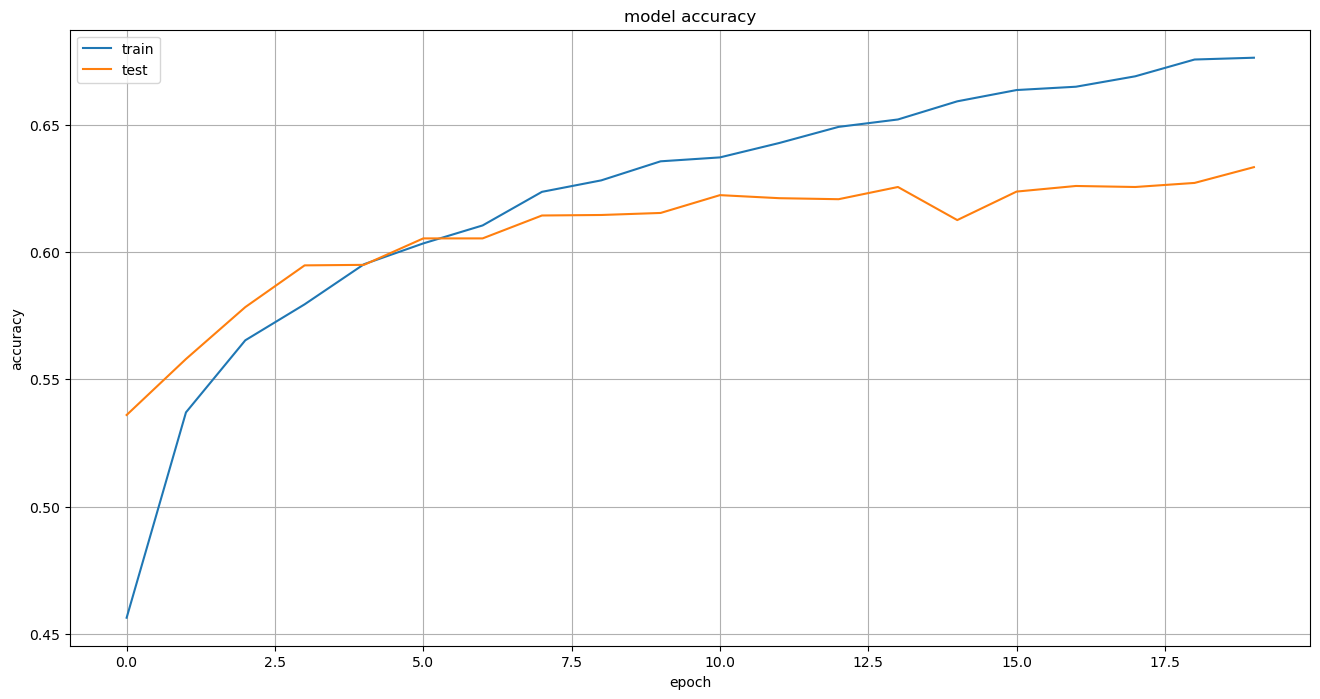

In [7]:
plothist(history)